# Séparabilité de données circulaires

CSI4506 Introduction à l’intelligence artificielle

Marcel Turcotte (École de science informatique et de génie électrique,
Université d’Ottawa)  
2025-10-17

## Données

Lors du cours, j’ai recommandé d’utiliser [TensorFlow
Playground](https://playground.tensorflow.org) comme un outil interactif
pour approfondir votre compréhension intuitive des réseaux de neurones
et des principes de l’apprentissage automatique. En particulier, j’ai
conseillé d’expérimenter avec le jeu de données comprenant un cercle
intérieur (classe 1) et un anneau extérieur (classe 0). Ce notebook
offre une exploration plus détaillée de ces concepts.

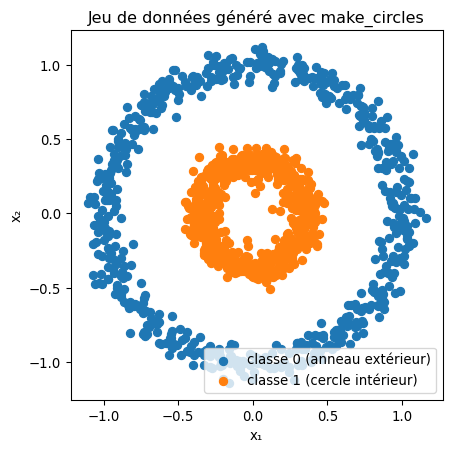

In [1]:
# Générer et tracer le jeu de données "cercles"
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

# Générer des données synthétiques
X, y = make_circles(n_samples=1200, factor=0.35, noise=0.06, random_state=42)

# Séparer les coordonnées pour le tracé
x1, x2 = X[:, 0], X[:, 1]

# Tracer les deux classes
plt.figure(figsize=(5, 5))
plt.scatter(x1[y==0], x2[y==0], color="C0", label="classe 0 (anneau extérieur)")
plt.scatter(x1[y==1], x2[y==1], color="C1", label="classe 1 (cercle intérieur)")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.title("Jeu de données généré avec make_circles")
plt.axis("equal") # assure que les cercles apparaissent ronds
plt.legend()
plt.show()

Il est clair que ce jeu de données n’est pas linéairement séparable dans
$(x_1, x_2)$ !

## Ingénierie des attributs

Lorsqu’on utilise un classificateur linéaire comme
[`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html),
il n’est pas possible de dériver des paramètres permettant une
classification précise des exemples donnés.

Dans TensorFlow Playground, les utilisateurs peuvent incorporer deux
attributs supplémentaires, $x_1^2$ et $x_2^2$. Cela permet de classer
les exemples en utilisant une configuration de réseau simple sans
couches cachées et un seul nœud de sortie. Lorsqu’on utilise la fonction
sigmoïde comme activation, cette configuration fonctionne effectivement
comme une régression logistique. Cependant, l’espace des attributs
devient à quatre dimensions, compliquant la visualisation directe.

Dans ce carnet, nous introduisons un seul attribut spécialement conçu
pour faciliter la visualisation. $$
r = x_1^2 + x_2^2,
$$ **(r)** représente la **distance au carré depuis l’origine** —
essentiellement le **rayon au carré** en coordonnées polaires.

### Intuition

-   Chaque point dans le plan 2-D original a des coordonnées
    $(x_1, x_2)$.
-   Si vous exprimez ces mêmes coordonnées en forme polaire, vous avez

$$
  x_1 = r^{1/2} \cos\theta, \quad x_2 = r^{1/2} \sin\theta,
$$ ou plus conventionnellement,
$r_{\text{polar}} = \sqrt{x_1^2 + x_2^2}$.

-   Ici, nous définissons $r = x_1^2 + x_2^2$, c’est-à-dire le **carré**
    de ce rayon.

Utiliser $r$ au lieu de $\sqrt{r}$ maintient la correspondance
différentiable et évite les racines carrées dans le modèle.

### Pourquoi c’est utile

Dans le jeu de données “cercle vs. anneau” :

-   Les points du **cercle intérieur** sont proches de l’origine, petit
    $r$.
-   Les points de l’**anneau extérieur** sont plus éloignés, grand $r$.

Ainsi, le problème qui est **non linéaire** en $(x_1, x_2)$ devient
**linéairement séparable** en $r$ :

$$
\text{intérieur si } r < r^*, \quad \text{extérieur si } r > r^*.
$$

Donc, $r$ est un **attribut encodant la distance radiale**, permettant à
un modèle linéaire comme la régression logistique de séparer les classes
avec un seul seuil en 1-D.

## Vue 3D

$(x_1,x_2,r)$ avec $r=x_1^2+x_2^2$

In [2]:
import numpy as np
from sklearn.datasets import make_circles
from sklearn.linear_model import LogisticRegression
import plotly.graph_objects as go

# --- notre nouvel attribut ---
r = x1**2 + x2**2

# --- ajuster la régression logistique uniquement sur r et obtenir le plan seuil ---

clf = LogisticRegression().fit(r.reshape(-1,1), y)
w = float(clf.coef_[0][0]); b = float(clf.intercept_[0])
r_thresh = -b / w

# --- nuage de points 3D de (x1, x2, r) ---

scatter = go.Scatter3d(
    x=x1, y=x2, z=r,
    mode="markers",
    marker=dict(size=3, color=y, colorscale="Viridis", showscale=False),
    hovertemplate="x1=%{x:.3f}<br>x2=%{y:.3f}<br>r=%{z:.3f}<extra></extra>",
    name="points"
)

# --- plan horizontal z = r_thresh ---

gx = np.linspace(x1.min()-0.2, x1.max()+0.2, 50)
gy = np.linspace(x2.min()-0.2, x2.max()+0.2, 50)
GX, GY = np.meshgrid(gx, gy)
GZ = np.full_like(GX, r_thresh)

plane = go.Surface(
    x=GX, y=GY, z=GZ,
    opacity=0.35, showscale=False,
    hoverinfo="skip",
    name="plan p=0.5"
)

fig = go.Figure(data=[plane, scatter])
fig.update_scenes(
    xaxis_title="x₁", yaxis_title="x₂", zaxis_title="r = x₁² + x₂²",
    aspectmode="cube",
    camera=dict(eye=dict(x=1.6, y=1.6, z=0.9))
)
fig.update_layout(margin=dict(l=0,r=0,b=0,t=20), title=f"Plan de décision à r* ≈ {r_thresh:.3f}")
fig

## Malheureusement, les objets graphiques plotly ne peuvent être visualisés qu'en HTML, pas en PDF.
## TODO : Explorer https://plotly.com/python/static-image-export/, cela pourrait être une solution de contournement.

## Séparabilité linéaire en 1D (espace-r)

En comparant deux modèles, `clf_r` utilise un seul attribut,
$r=x_1^2+x_2^2$, tandis que `quad` inclut des attributs polynomiaux de
degré 2.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

r = (x1**2 + x2**2).reshape(-1, 1)

# Modèles
clf_r = LogisticRegression().fit(r, y)

quad = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("logreg", LogisticRegression(max_iter=1000))
]).fit(X, y)

# Seuil r* (p=0.5) pour le modèle uniquement basé sur r

w = float(clf_r.coef_[0][0]); b = float(clf_r.intercept_[0])
r_thresh = -b / w if abs(w) > 1e-12 else None

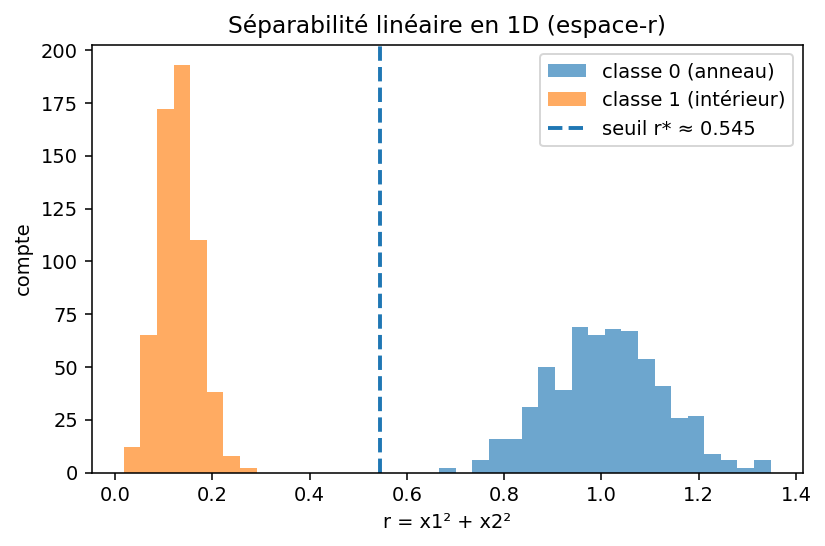

In [4]:
plt.figure(figsize=(6,4), dpi=140)
bins = np.linspace(r.min(), r.max(), 40)
plt.hist(r[y==0], bins=bins, alpha=0.65, label="classe 0 (anneau)")
plt.hist(r[y==1], bins=bins, alpha=0.65, label="classe 1 (intérieur)")
if r_thresh is not None:
    plt.axvline(r_thresh, linestyle="--", linewidth=2, label=f"seuil r* ≈ {r_thresh:.3f}")
plt.xlabel("r = x1² + x2²"); plt.ylabel("compte")
plt.title("Séparabilité linéaire en 1D (espace-r)")
plt.legend(); plt.tight_layout(); plt.show()

## Modèle logistique dans l’espace r en 1D

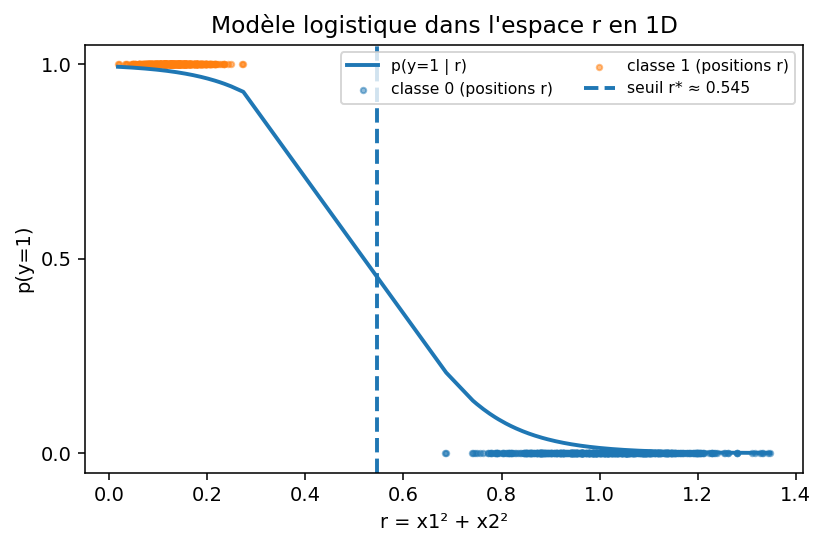

In [5]:
order = np.argsort(r.ravel())
r_sorted = r.ravel()[order]
p_sorted = clf_r.predict_proba(r_sorted.reshape(-1,1))[:,1]

plt.figure(figsize=(6,4), dpi=140)
plt.plot(r_sorted, p_sorted, linewidth=2, label="p(y=1 | r)")
plt.scatter(r[y==0], np.zeros_like(r[y==0]), s=8, alpha=0.5, label="classe 0 (positions r)")
plt.scatter(r[y==1], np.ones_like(r[y==1]), s=8, alpha=0.5, label="classe 1 (positions r)")
if r_thresh is not None:
    plt.axvline(r_thresh, linestyle="--", linewidth=2, label=f"seuil r* ≈ {r_thresh:.3f}")
plt.yticks([0, 0.5, 1]); plt.ylim(-0.05, 1.05)
plt.xlabel("r = x1² + x2²"); plt.ylabel("p(y=1)")
plt.title("Modèle logistique dans l'espace r en 1D")
plt.legend(loc="best", ncol=2, fontsize=8)
plt.tight_layout(); plt.show()

## Frontière de décision à partir de r = x1² + x2² (logistique)

Utilise `clf_r.predict_proba` pour tracer la frontière de décision.

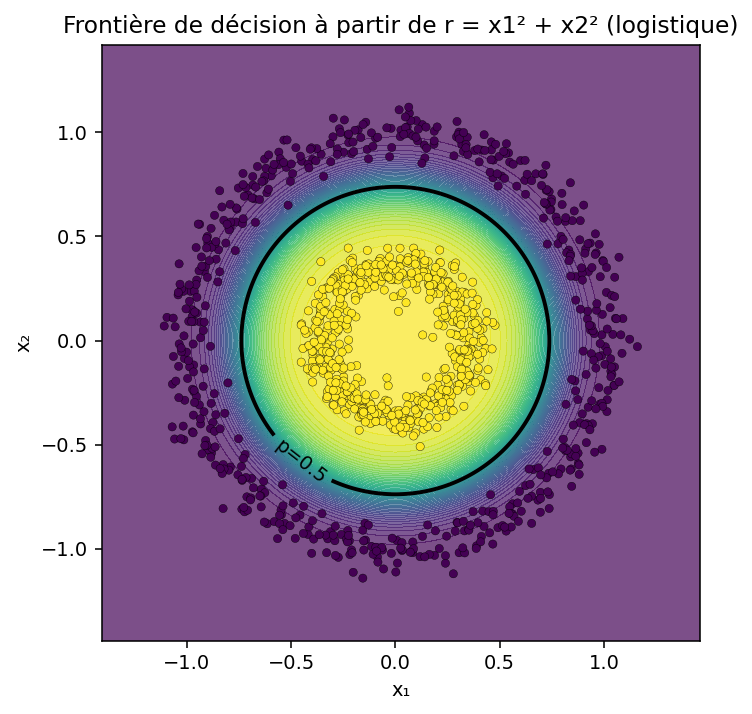

In [6]:
xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-0.3, X[:,0].max()+0.3, 400),
    np.linspace(X[:,1].min()-0.3, X[:,1].max()+0.3, 400)
)
grid = np.c_[xx.ravel(), yy.ravel()]
r_grid = (grid[:,0]**2 + grid[:,1]**2).reshape(-1,1)
p_r = clf_r.predict_proba(r_grid)[:, 1].reshape(xx.shape)

plt.figure(figsize=(5.2,5.2), dpi=140)
cf = plt.contourf(xx, yy, p_r, levels=50, alpha=0.7)
cs = plt.contour(xx, yy, p_r, levels=[0.5], linewidths=2, colors="k")
plt.scatter(X[:,0], X[:,1], c=y, s=18, edgecolor="k", linewidth=0.2)
plt.clabel(cs, fmt={0.5:"p=0.5"})
plt.title("Frontière de décision à partir de r = x1² + x2² (logistique)")
plt.xlabel("x₁"); plt.ylabel("x₂"); plt.tight_layout(); plt.show()

## Frontière de décision à partir des attributs quadratiques (logistique)

Utilise `quad.predict_proba` pour tracer la frontière de décision. (En
effet, les deux modèles produisent le même résultat.)

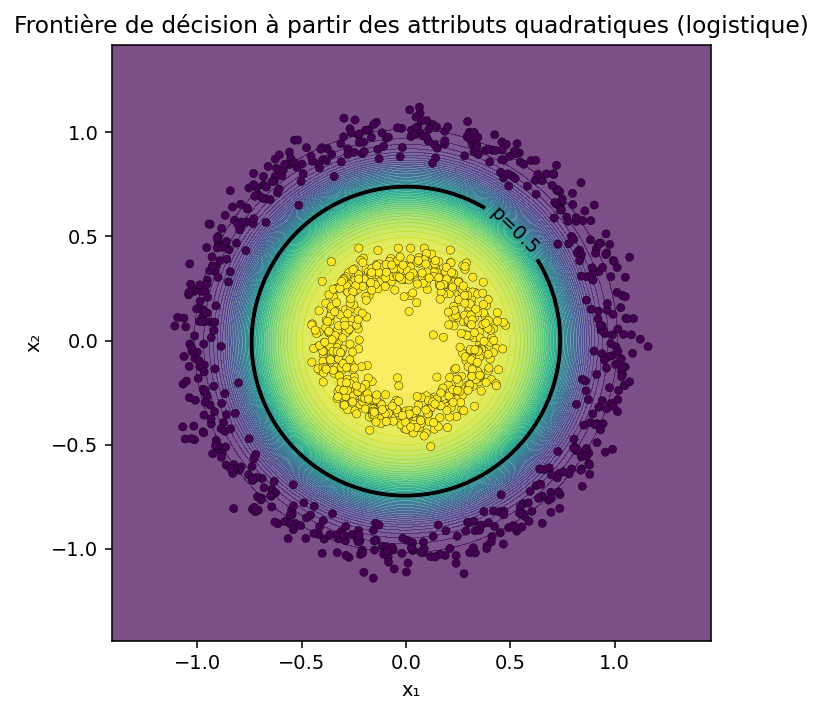

In [7]:
p_quad = quad.predict_proba(grid)[:, 1].reshape(xx.shape)

plt.figure(figsize=(5.2,5.2), dpi=140)
cf = plt.contourf(xx, yy, p_quad, levels=50, alpha=0.7)
cs2 = plt.contour(xx, yy, p_quad, levels=[0.5], linewidths=2, colors="k")
plt.scatter(X[:,0], X[:,1], c=y, s=18, edgecolor="k", linewidth=0.2)
plt.clabel(cs2, fmt={0.5:"p=0.5"})
plt.title("Frontière de décision à partir des attributs quadratiques (logistique)")
plt.xlabel("x₁"); plt.ylabel("x₂"); plt.tight_layout(); plt.show()

## Réseau de neurones

Pour approfondir notre compréhension du comportement des réseaux de
neurones, configurons un modèle pour n’utiliser que les attributs $x_1$
et $x_2$. Nous allons mettre en place deux couches cachées, chacune
composée de quatre neurones. Dans mes expériences, la fonction
d’activation `Tanh` a conduit à une convergence rapide du réseau. La
fonction `Sigmoid` a également convergé, bien que plus lentement. De
même, la fonction d’activation `ReLU` a permis une convergence rapide
mais a produit une frontière de décision composée de segments linéaires.

In [8]:
from sklearn.model_selection import train_test_split

# Réseau MLP Keras à deux couches (4 + 4) sur make_circles + tracé de la frontière de décision

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 0) Reproductibilité

np.random.seed(42)
tf.random.set_seed(42)

# 1) Données

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [9]:
# 2) Modèle : 2 couches cachées avec 4 unités chacune
# tanh fonctionne bien ici en raison de la symétrie circulaire (ReLU est bien aussi).

model = keras.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(4, activation="tanh"),
    layers.Dense(4, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
])

In [10]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [11]:
# Optionnel : arrêt précoce pour une convergence rapide
es = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor="val_loss")

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=300,
    batch_size=64,
    verbose=0,
    callbacks=[es]
)

print(f"Train acc: {history.history['accuracy'][-1]:.3f} | "
      f"Val acc (best): {max(history.history['val_accuracy']):.3f}")

Train acc: 1.000 | Val acc (best): 1.000

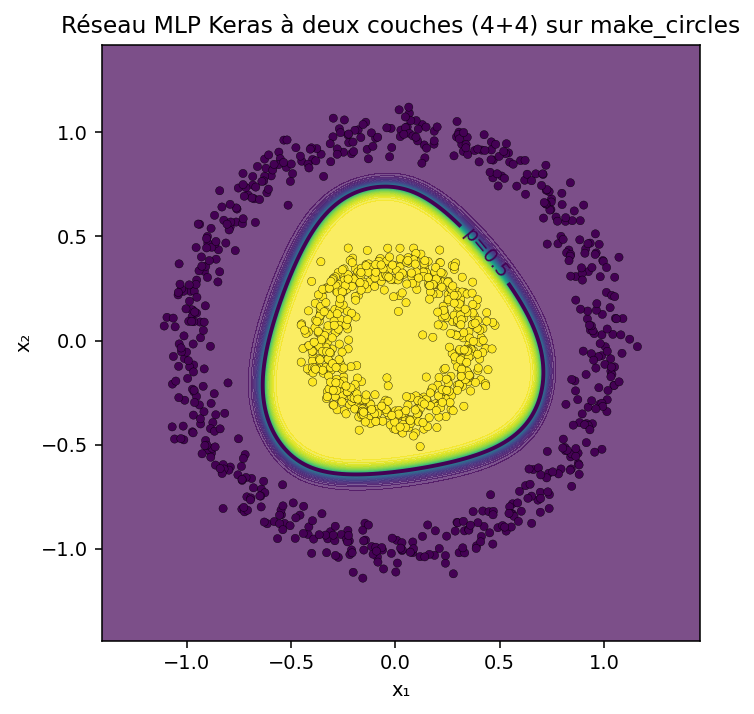

In [12]:
# 3) Fonction d'aide au tracé : frontière de décision dans le plan original (x1, x2)

def plot_decision_boundary(model, X, y, title="Frontière de décision MLP Keras"):
    # grille sur le plan d'entrée
    pad = 0.3
    x1_min, x1_max = X[:,0].min()-pad, X[:,0].max()+pad
    x2_min, x2_max = X[:,1].min()-pad, X[:,1].max()+pad
    xx, yy = np.meshgrid(
        np.linspace(x1_min, x1_max, 400),
        np.linspace(x2_min, x2_max, 400)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    # prédire les probabilités sur la grille
    p = model.predict(grid, verbose=0).reshape(xx.shape)

    # probabilités remplies + contour p=0.5 + points de données
    plt.figure(figsize=(5.2, 5.2), dpi=140)
    plt.contourf(xx, yy, p, levels=50, alpha=0.7)
    cs = plt.contour(xx, yy, p, levels=[0.5], linewidths=2)
    plt.scatter(X[:,0], X[:,1], c=y, s=18, edgecolor="k", linewidth=0.2)
    plt.clabel(cs, fmt={0.5: "p=0.5"})
    plt.title(title)
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.tight_layout()
    plt.show()

plot_decision_boundary(model, X, y, title="Réseau MLP Keras à deux couches (4+4) sur make_circles")

## Ensemble de données XOR

Cet exemple utilise un ensemble de données classique, caractérisé par un
motif “ou exclusif” (XOR), qui est fréquemment utilisé pour démontrer
des frontières de décision non linéaires et pour souligner la nécessité
des réseaux de neurones dans le traitement de telles complexités.

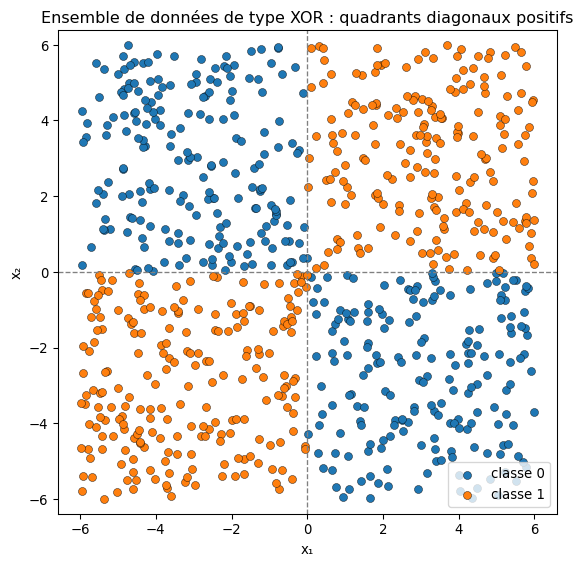

In [13]:
# 1. Générer l'ensemble de données XOR

n_samples = 800
rng = np.random.default_rng(42)

# Attributs échantillonnés uniformément dans [-6, 6]
X = rng.uniform(-6, 6, size=(n_samples, 2))
x1, x2 = X[:, 0], X[:, 1]

# Étiquettes : positives si (x1 et x2) ont le même signe (en haut à gauche ou en bas à droite)
y = ((x1 * x2) > 0).astype(int)

# 2. Visualiser les données

plt.figure(figsize=(6, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1],
            color="C0", label="classe 0", edgecolor="k", linewidth=0.3)
plt.scatter(X[y == 1, 0], X[y == 1, 1],
            color="C1", label="classe 1", edgecolor="k", linewidth=0.3)

# Dessiner les axes pour plus de clarté
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.axvline(0, color="gray", linestyle="--", linewidth=1)

plt.xlabel("x₁")
plt.ylabel("x₂")
plt.title("Ensemble de données de type XOR : quadrants diagonaux positifs")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()

Serait-il raisonnable de penser que les attributs conçus pour les
données circulaires pourraient être bénéfiques dans ce contexte ?

In [14]:
r = (x1**2 + x2**2).reshape(-1, 1)

# Modèles
clf_r = LogisticRegression().fit(r, y)

quad = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("logreg", LogisticRegression(max_iter=1000))
]).fit(X, y)

# Seuil r* (p=0.5) pour le modèle basé uniquement sur r

w = float(clf_r.coef_[0][0]); b = float(clf_r.intercept_[0])
r_thresh = -b / w if abs(w) > 1e-12 else None

Pas du tout!

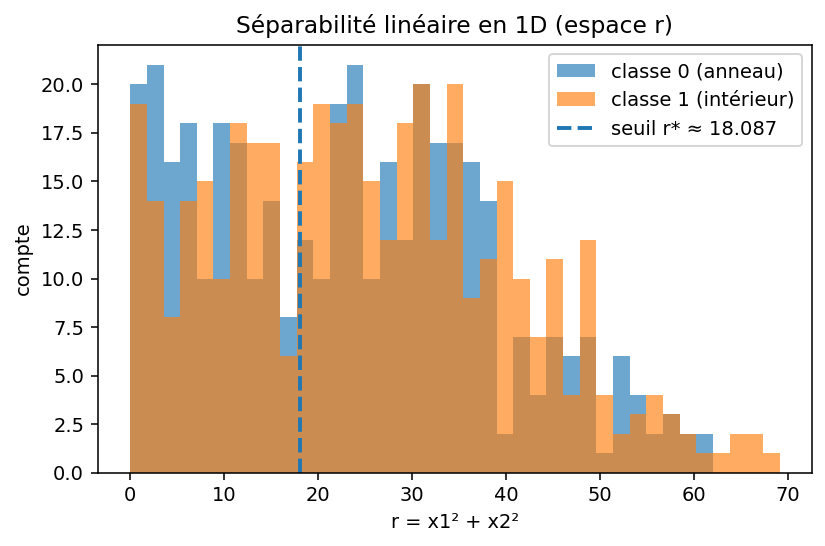

In [15]:
plt.figure(figsize=(6,4), dpi=140)
bins = np.linspace(r.min(), r.max(), 40)
plt.hist(r[y==0], bins=bins, alpha=0.65, label="classe 0 (anneau)")
plt.hist(r[y==1], bins=bins, alpha=0.65, label="classe 1 (intérieur)")
if r_thresh is not None:
    plt.axvline(r_thresh, linestyle="--", linewidth=2, label=f"seuil r* ≈ {r_thresh:.3f}")
plt.xlabel("r = x1² + x2²"); plt.ylabel("compte")
plt.title("Séparabilité linéaire en 1D (espace r)")
plt.legend(); plt.tight_layout(); plt.show()

Pour résoudre le problème en utilisant la régression logistique, il
serait nécessaire de créer de nouveaux attributs. Pouvez-vous proposer
de tels attributs ?

Qu’en est-il de notre modèle de réseau de neurones ? Pouvons-nous
raisonnablement nous attendre à ce qu’il fonctionne bien sur cet
ensemble de données ? Vous trouverez ci-dessous une copie verbatim du
code.

In [16]:
# 0) Reproductibilité

np.random.seed(42)
tf.random.set_seed(42)

# 1) Données

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [17]:
# 2) Modèle : 2 couches cachées avec 4 unités chacune
# tanh fonctionne bien ici en raison de la symétrie circulaire (ReLU fonctionne aussi).

model = keras.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(4, activation="tanh"),
    layers.Dense(4, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
])

In [18]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [19]:
# Optionnel : arrêt précoce pour une convergence rapide
es = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor="val_loss")

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=300,
    batch_size=64,
    verbose=0,
    callbacks=[es]
)

print(f"Train acc: {history.history['accuracy'][-1]:.3f} | "
      f"Val acc (meilleur): {max(history.history['val_accuracy']):.3f}")

Train acc: 0.965 | Val acc (meilleur): 0.995

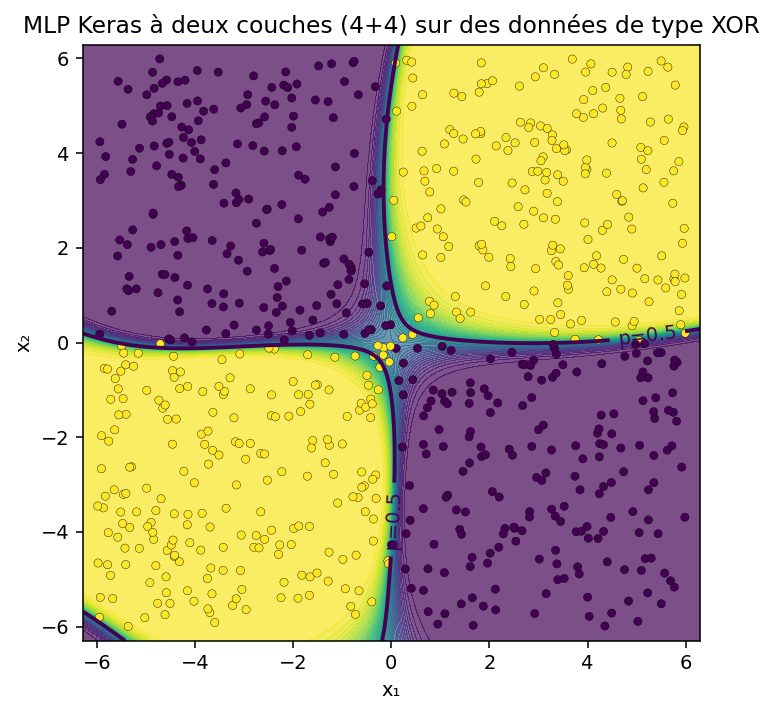

In [20]:
# 3) Outil de tracé : frontière de décision dans le plan original (x1, x2)

def plot_decision_boundary(model, X, y, title="Frontière de décision du MLP Keras"):
    # grille sur le plan d'entrée
    pad = 0.3
    x1_min, x1_max = X[:,0].min()-pad, X[:,0].max()+pad
    x2_min, x2_max = X[:,1].min()-pad, X[:,1].max()+pad
    xx, yy = np.meshgrid(
        np.linspace(x1_min, x1_max, 400),
        np.linspace(x2_min, x2_max, 400)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    # prédire les probabilités sur la grille
    p = model.predict(grid, verbose=0).reshape(xx.shape)

    # probabilités remplies + contour p=0.5 + points de données
    plt.figure(figsize=(5.2, 5.2), dpi=140)
    plt.contourf(xx, yy, p, levels=50, alpha=0.7)
    cs = plt.contour(xx, yy, p, levels=[0.5], linewidths=2)
    plt.scatter(X[:,0], X[:,1], c=y, s=18, edgecolor="k", linewidth=0.2)
    plt.clabel(cs, fmt={0.5: "p=0.5"})
    plt.title(title)
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.tight_layout()
    plt.show()

plot_decision_boundary(model, X, y, title="MLP Keras à deux couches (4+4) sur des données de type XOR")

Plutôt impressionnant, n’est-ce pas ?

La leçon clé est que l’ingénierie des attributs combinée avec des
modèles d’apprentissage automatique de base peut donner des résultats
satisfaisants, notamment dans des scénarios simples comme ceux illustrés
ici. Lorsque la visualisation des données est possible ou qu’une
expertise du domaine est disponible, ce processus est généralement
accessible. Cependant, dans des situations plus complexes impliquant des
centaines ou des milliers d’attributs et des domaines complexes, les
réseaux de neurones sont particulièrement efficaces. Leur capacité à
apprendre des représentations hiérarchiques des attributs leur permet
d’exceller dans ces contextes difficiles.